# Developing "Momentum" Trading Strategy
* Many different takes on this strategy,
* It is also referred to as trend following,
* Whatever you do and call it, you first need to research potential trading signals.

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Download Data to be used: 
* Many services for this, some paid some free 
* Yahoo Finance API
* Typically trading "systems" involve a number of securities
* For this demonstration we are just going to look at GLD --> the gold ETF

In [2]:
gld = pdr.get_data_yahoo('GLD')
day = np.arange(1, len(gld) + 1)
gld['day'] = day
gld.drop(columns=['Adj Close', 'Volume'], inplace = True)
gld = gld[['day', 'Open', 'High', 'Low', 'Close']]
gld.head(100)

,day,Open,High,Low,Close
Date,,,,,
2017-07-25,1,118.989998,119.320000,118.790001,118.919998
2017-07-26,2,118.570000,120.150002,118.550003,119.879997
2017-07-27,3,120.099998,120.139999,119.279999,119.790001
2017-07-28,4,120.150002,120.860001,120.139999,120.690002
2017-07-31,5,120.500000,120.809998,120.449997,120.750000
...,...,...,...,...,...
2017-12-07,96,119.010002,119.239998,118.099998,118.489998
2017-12-08,97,118.489998,118.919998,118.330002,118.480003
2017-12-11,98,118.370003,118.540001,117.800003,118.010002


In [3]:
gld.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2017-07-25 to 2022-07-22
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   day     1258 non-null   int32  
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   float64
dtypes: float64(4), int32(1)
memory usage: 54.1 KB


In [4]:
gld.drop_duplicates(inplace = True)

In [5]:
gld.describe()

,day,Open,High,Low,Close
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000
mean,629.500000,147.509213,148.103808,146.853188,147.498712
std,363.297628,23.631276,23.801850,23.390212,23.615601
min,1.000000,111.459999,111.879997,111.059998,111.099998
25%,315.250000,123.197502,123.617500,122.902502,123.195002
50%,629.500000,146.365005,146.894997,145.810005,146.595001
75%,943.750000,169.300003,169.907501,168.607498,169.345005
max,1258.000000,193.740005,194.449997,192.520004,193.889999


In [6]:
gld.corr()

,day,Open,High,Low,Close
day,1.000000,0.889348,0.889208,0.890689,0.889551
Open,0.889348,1.000000,0.999676,0.999545,0.999247
High,0.889208,0.999676,1.000000,0.999491,0.999654
Low,0.890689,0.999545,0.999491,1.000000,0.999705
Close,0.889551,0.999247,0.999654,0.999705,1.000000


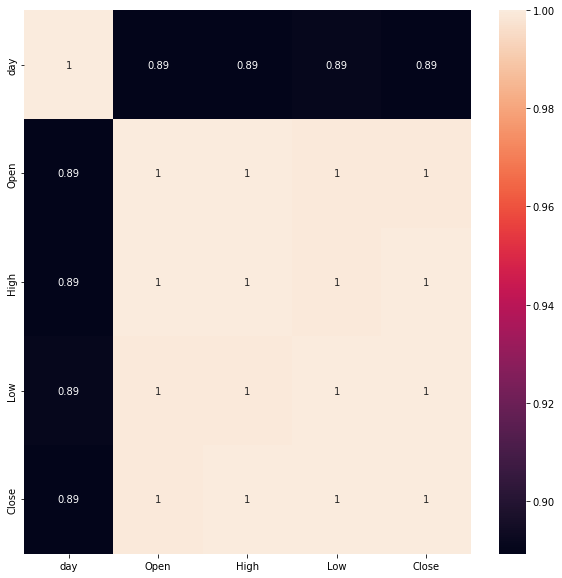

In [7]:
correlation = gld.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation, annot=True)
plt.show()

### 2. Add data/transform data
* calculate signal based on some price or statistical action
* we are going to try a moving average crossover to generate signals
* for this strategy we will always by "in" a trade, either long or short
* we are modeling; this means real life variation should be expected

#### Add moving averages to the data frame

In [8]:
gld['9-day'] = gld['Close'].rolling(50).mean()
gld['21-day'] = gld['Close'].rolling(200).mean()
gld[19:25]

,day,Open,High,Low,Close,9-day,21-day
Date,,,,,,,
2017-08-21,20,122.540001,122.980003,122.500000,122.760002,NaN,NaN
2017-08-22,21,122.559998,122.559998,121.849998,122.209999,NaN,NaN
2017-08-23,22,122.580002,122.690002,122.309998,122.669998,NaN,NaN
2017-08-24,23,122.389999,122.639999,122.129997,122.290001,NaN,NaN
2017-08-25,24,122.769997,123.019997,121.290001,122.739998,NaN,NaN
2017-08-28,25,123.330002,124.730003,123.330002,124.690002,NaN,NaN


#### Add "signal" column  

In [9]:
gld['signal'] = np.where(gld['9-day'] > gld['21-day'], 1, 0)
gld['signal'] = np.where(gld['9-day'] < gld['21-day'], -1, gld['signal'])
gld.dropna(inplace=True)
gld.head()

,day,Open,High,Low,Close,9-day,21-day,signal
Date,,,,,,,,
2018-05-09,200,124.449997,124.870003,124.239998,124.330002,125.8866,123.83075,1
2018-05-10,201,125.220001,125.370003,124.750000,125.180000,125.8902,123.86205,1
2018-05-11,202,125.570000,125.589996,124.940002,125.000000,125.8958,123.88765,1
2018-05-14,203,125.160004,125.209999,124.440002,124.489998,125.8778,123.91115,1
2018-05-15,204,122.820000,122.820000,122.129997,122.480003,125.8238,123.92010,1


#### Calculate Instantaneous returns/system returns

In [10]:
gld['return'] = np.log(gld['Close']).diff()
gld['system_return'] = gld['signal'] * gld['return']
gld['entry'] = gld.signal.diff()
gld.dropna(inplace=True)
gld.head()

,day,Open,High,Low,Close,9-day,21-day,signal,return,system_return,entry
Date,,,,,,,,,,,
2018-05-10,201,125.220001,125.370003,124.750000,125.180000,125.8902,123.86205,1,0.006813,0.006813,0.0
2018-05-11,202,125.570000,125.589996,124.940002,125.000000,125.8958,123.88765,1,-0.001439,-0.001439,0.0
2018-05-14,203,125.160004,125.209999,124.440002,124.489998,125.8778,123.91115,1,-0.004088,-0.004088,0.0
2018-05-15,204,122.820000,122.820000,122.129997,122.480003,125.8238,123.92010,1,-0.016278,-0.016278,0.0
2018-05-16,205,122.379997,122.610001,122.029999,122.290001,125.7390,123.92780,1,-0.001552,-0.001552,0.0


#### Plot trades on time series

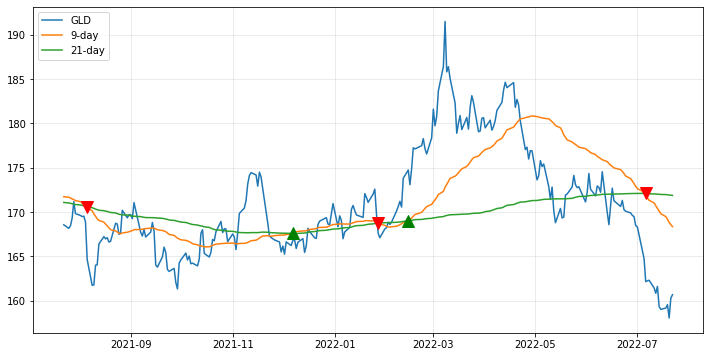

In [11]:
plt.rcParams['figure.figsize'] = 12, 6
plt.grid(True, alpha = .3)
plt.plot(gld.iloc[-252:]['Close'], label = 'GLD')
plt.plot(gld.iloc[-252:]['9-day'], label = '9-day')
plt.plot(gld.iloc[-252:]['21-day'], label = '21-day')
plt.plot(gld[-252:].loc[gld.entry == 2].index, gld[-252:]['9-day'][gld.entry == 2], '^',
         color = 'g', markersize = 12)
plt.plot(gld[-252:].loc[gld.entry == -2].index, gld[-252:]['21-day'][gld.entry == -2], 'v',
         color = 'r', markersize = 12)
plt.legend(loc=2);

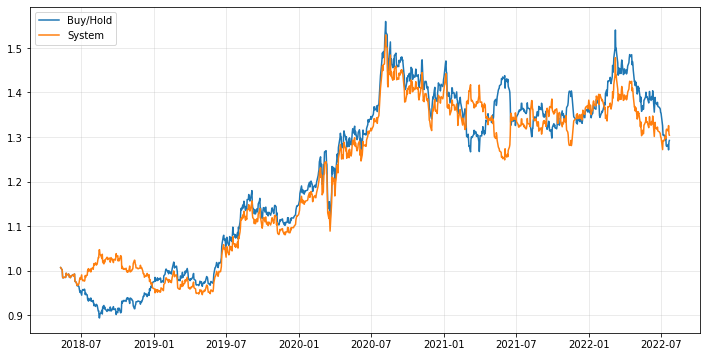

In [12]:
plt.plot(np.exp(gld['return']).cumprod(), label='Buy/Hold')
plt.plot(np.exp(gld['system_return']).cumprod(), label='System')
plt.legend(loc=2)
plt.grid(True, alpha=.3)

In [13]:
np.exp(gld['return']).cumprod()[-1] -1

0.29228662271935857

In [14]:
np.exp(gld['system_return']).cumprod()[-1] -1

0.30397343646646857

In [15]:
np.exp(gld['return']).cumprod() -1

Date
2018-05-10    0.006837
2018-05-11    0.005389
2018-05-14    0.001287
2018-05-15   -0.014880
2018-05-16   -0.016408
                ...   
2022-07-18    0.280142
2022-07-19    0.283198
2022-07-20    0.271133
2022-07-21    0.289069
2022-07-22    0.292287
Name: return, Length: 1058, dtype: float64

In [16]:
np.exp(gld['system_return']).cumprod() -1

Date
2018-05-10    0.006837
2018-05-11    0.005389
2018-05-14    0.001287
2018-05-15   -0.014880
2018-05-16   -0.016408
                ...   
2022-07-18    0.316345
2022-07-19    0.313209
2022-07-20    0.325673
2022-07-21    0.307228
2022-07-22    0.303973
Name: system_return, Length: 1058, dtype: float64